In [1]:
import os 
import sys

import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm
from matplotlib.ticker import LinearLocator


sys.path.append("../src/modeval")
from modulescomparison import ModulesComparison
from modulecontainers import Modules 

In [2]:
sys.path.insert(0,os.path.abspath("../src/modeval/"))

In [3]:
## Get the known RegulonDB network with modification described in inspect_input_elements.ipynb
known_trn = pd.read_csv("../data/Regulatory/QCd_Network.csv", index_col=0)
known_trn.head()

,regulatorId,regulatorName,RegulatorGeneName,regulatedId,regulatedName,function,confidenceLevel
313,RDBECOLIPDC00358,DsrA,dsrA,RDBECOLIGNC00450,hns,-,S
315,RDBECOLIPDC00358,DsrA,dsrA,RDBECOLIGNC00539,lrp,-,S
316,RDBECOLIPDC00358,DsrA,dsrA,RDBECOLIGNC00804,rbsA,-,S
317,RDBECOLIPDC00358,DsrA,dsrA,RDBECOLIGNC00805,rbsB,-,S
318,RDBECOLIPDC00358,DsrA,dsrA,RDBECOLIGNC00806,rbsC,-,S


In [4]:
## Load the annotation E Coli 
annotation = pd.read_csv("../data/Annotation/gene_info.csv")
annotation.head()

,locus_tag,gene_name,old_locus_tag,start,end,strand,gene_product,COG,uniprot
0,b0001,thrL,NaN,190,255,+,thr operon leader peptide,No COG annotation,P0AD86
1,b0002,thrA,NaN,337,2799,+,fused aspartate kinase/homoserine dehydrogenase 1,Amino acid transport and metabolism,P00561
2,b0003,thrB,NaN,2801,3733,+,homoserine kinase,Nucleotide transport and metabolism,P00547
3,b0004,thrC,NaN,3734,5020,+,threonine synthase,Amino acid transport and metabolism,P00934
4,b0005,yaaX,NaN,5234,5530,+,DUF2502 domain-containing protein YaaX,Function unknown,P75616


In [5]:
# Define the set of all known genes (E)
all_genes = annotation.locus_tag.values 

# Define a set of all known regulators
known_regulators = known_trn['RegulatorGeneName'].unique()

# Map gene names to locus tags for comparable output with GENIE3 ouput
annotation_map = annotation[annotation.gene_name.notna()].set_index("gene_name")["locus_tag"].to_dict()
known_trn['targets_tags'] = known_trn["regulatedName"].map(annotation_map)

In [6]:
# Iterate over regulators and gene targets to load a graph from edges
known_ecoli_trn = nx.Graph() 
for i in known_trn[['RegulatorGeneName', 'targets_tags']].itertuples():
    known_ecoli_trn.add_edges_from([tuple([i[1], i[2]])]) 
    
edges_ecoli_trn = known_ecoli_trn.edges

# Find the neighbors of the regulators to define gene targets 
known_modules = []
for reg in known_regulators:
    known_modules.append(list(known_ecoli_trn.neighbors(reg)))

In [7]:
## Load the results from GENIE3 undirected run w/o regulator input
genie3_undirected = pd.read_csv("../data/predicted_results/GENIE3_5_ET_Ksqrt_nTrees1000_nRegs0_2024-06-11.csv", index_col=0)
genie3_undirected.head()

,regulatoryGene,targetGene,weight
1,b0573,b0574,0.041188
2,b0575,b0574,0.039607
3,b0574,b0575,0.039262
4,b2000,b2001,0.038284
5,b1973,b0296,0.035970


In [8]:
## Load the results from GENIE3 directed run w/o regulator input
genie3_directed = pd.read_csv("../data/predicted_results/GENIE3_4_RF_Ksqrt_nTrees1000_nRegs106_2024-06-26.csv", index_col=0)
genie3_directed.head()

,regulatoryGene,targetGene,weight
1,b1921,b1071,0.344796
2,b1921,b1924,0.340820
3,b0571,b0572,0.339699
4,b1921,b1925,0.336633
5,b1921,b1926,0.330987


In [ ]:
directed_list_edges = []
undirected_list_edges = []

for j in range (100,10000,100):
    ecoli_trn_undirected = nx.Graph()
    ecoli_trn_undirected.add_edges_from([tuple(val) for val in genie3_undirected[['regulatoryGene', 'targetGene']].head(j).values])
    ecoli_trn_directed = nx.Graph()
    ecoli_trn_directed.add_edges_from([tuple(val) for val in genie3_directed[['regulatoryGene', 'targetGene']].head(j).values])
    directed_sets = [set(module) for module in ecoli_trn_directed]
    undirected_sets = [set(module) for module in ecoli_trn_undirected]
    ModulesB = Modules(known_modules)
    ModulesA_directed = Modules(directed_sets)
    ModulesA_undirected = Modules(undirected_sets)

    undirect_comp = ModulesComparison(ModulesA_undirected, ModulesB, all_genes).score(None)
    direct_comp = ModulesComparison(ModulesA_directed, ModulesB, all_genes).score(None)

    directed_list_edges.append((j, direct_comp['precision'], direct_comp['recall'], direct_comp['recovery'], direct_comp['relevance'], direct_comp['F1rprr']))
    undirected_list_edges.append((j, undirect_comp['precision'], undirect_comp['recall'], undirect_comp['recovery'], undirect_comp['relevance'], undirect_comp['F1rprr']))

directed_scores_edges = pd.DataFrame(directed_list_edges, columns=['edges', 'precision', 'recall', 'recovery', 'relevance', 'f1rprr'])
undirected_scores_edges = pd.DataFrame(undirected_list_edges, columns=['edges', 'precision', 'recall', 'recovery', 'relevance', 'f1rprr'])

In [ ]:
directed_scores_edges

In [ ]:
undirected_scores_edges

In [ ]:
plt.figure(figsize=(10, 6))

# Plot for directed scores
plt.plot(directed_scores_edges['edges'], directed_scores_edges['f1rprr'], marker='o', linestyle='-', label='Directed')
plt.xlabel('Edges')
plt.ylabel('F1 RPRR')
plt.title('F1 RPRR Scores vs Edges')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))

# Plot for directed scores
plt.plot(undirected_scores_edges['edges'], undirected_scores_edges['f1rprr'], marker='o', linestyle='-', label='Directed')
plt.xlabel('Edges')
plt.ylabel('F1 RPRR')
plt.title('F1 RPRR Scores vs Edges')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
max_undirected_score_edges = undirected_scores_edges.loc[undirected_scores_edges['f1rprr'].idxmax()]
max_directed_score_edges = directed_scores_edges.loc[directed_scores_edges['f1rprr'].idxmax()]

print("Edge count with highest undirected F1rprr score:")
print(max_undirected_score_edges)
print("Edge count with highest directed F1rprr score:")
print(max_directed_score_edges)

In [10]:
directed_list_edges = []
undirected_list_edges = []

for j in range (100,10000,100):
    ecoli_trn_undirected = nx.Graph()
    ecoli_trn_undirected.add_edges_from([tuple(val) for val in genie3_undirected[['regulatoryGene', 'targetGene']].head(j).values])
    ecoli_trn_directed = nx.Graph()
    ecoli_trn_directed.add_edges_from([tuple(val) for val in genie3_directed[['regulatoryGene', 'targetGene']].head(j).values])
    louvain_community_undirected = nx.community.louvain_communities(ecoli_trn_undirected, weight='weight', resolution=1, threshold=1e-7, seed=None)
    louvain_community_directed = nx.community.louvain_communities(ecoli_trn_directed, weight='weight', resolution=1, threshold=1e-7, seed=None)
    louvain_directed_sets = [set(module) for module in louvain_community_directed]
    louvain_undirected_sets = [set(module) for module in louvain_community_undirected]
    ModulesB = Modules(known_modules)
    ModulesA_directed = Modules(louvain_directed_sets)
    ModulesA_undirected = Modules(louvain_undirected_sets)

    undirect_comp = ModulesComparison(ModulesA_undirected, ModulesB, all_genes).score(None)
    direct_comp = ModulesComparison(ModulesA_directed, ModulesB, all_genes).score(None)

    directed_list_edges.append((j, direct_comp['precision'], direct_comp['recall'], direct_comp['recovery'], direct_comp['relevance'], direct_comp['F1rprr']))
    undirected_list_edges.append((j, undirect_comp['precision'], undirect_comp['recall'], undirect_comp['recovery'], undirect_comp['relevance'], undirect_comp['F1rprr']))

directed_scores_edges = pd.DataFrame(directed_list_edges, columns=['edges', 'precision', 'recall', 'recovery', 'relevance', 'f1rprr'])
undirected_scores_edges = pd.DataFrame(undirected_list_edges, columns=['edges', 'precision', 'recall', 'recovery', 'relevance', 'f1rprr'])

In [18]:
directed_scores_edges

,edges,precision,recall,recovery,relevance,f1rprr
0,100,0.003072,0.006595,0.364974,0.072843,0.008103
1,200,0.004838,0.012334,0.288819,0.127552,0.013374
2,300,0.005313,0.013826,0.253103,0.140376,0.014726
3,400,0.005710,0.015181,0.251008,0.150304,0.015896
4,500,0.006085,0.016634,0.229708,0.155251,0.017004
...,...,...,...,...,...,...
94,9500,0.006268,0.005842,0.101394,0.029559,0.010683
95,9600,0.006445,0.005382,0.087994,0.029385,0.010353
96,9700,0.006439,0.005523,0.091693,0.028689,0.010468
97,9800,0.006623,0.005669,0.092593,0.028115,0.010703


In [19]:
undirected_scores_edges

,edges,precision,recall,recovery,relevance,f1rprr
0,100,0.000404,0.002956,0.142815,0.037747,0.001406
1,200,0.000567,0.005528,0.140908,0.065594,0.002035
2,300,0.000700,0.007196,0.153593,0.084282,0.002523
3,400,0.001172,0.009957,0.153647,0.098142,0.004123
4,500,0.001259,0.011827,0.156166,0.113536,0.004475
...,...,...,...,...,...,...
94,9500,0.014022,0.047709,0.098930,0.272630,0.037718
95,9600,0.014131,0.047410,0.098850,0.272492,0.037863
96,9700,0.014181,0.046990,0.098377,0.269044,0.037851
97,9800,0.014198,0.046769,0.097956,0.268584,0.037826


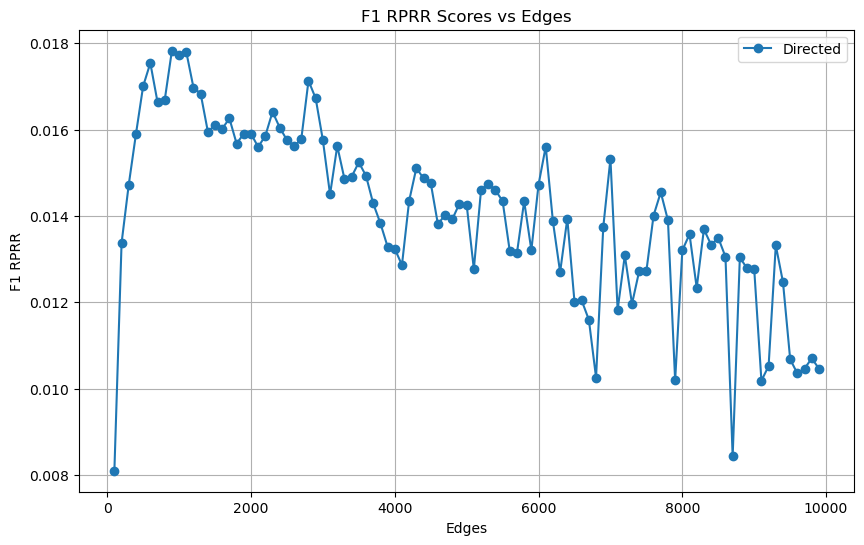

In [23]:
plt.figure(figsize=(10, 6))

# Plot for directed scores
plt.plot(directed_scores_edges['edges'], directed_scores_edges['f1rprr'], marker='o', linestyle='-', label='Directed')
plt.xlabel('Edges')
plt.ylabel('F1 RPRR')
plt.title('F1 RPRR Scores vs Edges')
plt.legend()
plt.grid(True)
plt.show()

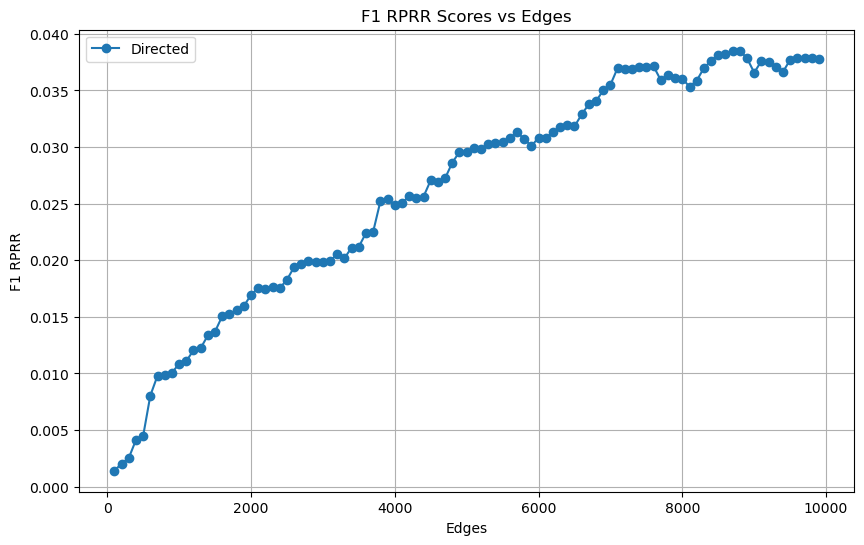

In [22]:
plt.figure(figsize=(10, 6))

# Plot for directed scores
plt.plot(undirected_scores_edges['edges'], undirected_scores_edges['f1rprr'], marker='o', linestyle='-', label='Directed')
plt.xlabel('Edges')
plt.ylabel('F1 RPRR')
plt.title('F1 RPRR Scores vs Edges')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
max_undirected_score_edges = undirected_scores_edges.loc[undirected_scores_edges['f1rprr'].idxmax()]
max_directed_score_edges = directed_scores_edges.loc[directed_scores_edges['f1rprr'].idxmax()]

print("Edge count with highest undirected F1rprr score:")
print(max_undirected_score_edges)
print("Edge count with highest directed F1rprr score:")
print(max_directed_score_edges)

Edge count with highest undirected F1rprr score:
edges        8800.000000
precision       0.014349
recall          0.048245
recovery        0.102073
relevance       0.273725
f1rprr          0.038510
Name: 87, dtype: float64
Edge count with highest directed F1rprr score:
edges        900.000000
precision      0.006767
recall         0.015537
recovery       0.177181
relevance      0.150753
f1rprr         0.017824
Name: 8, dtype: float64


In [16]:
ecoli_trn_undirected = nx.Graph()
ecoli_trn_undirected.add_edges_from([tuple(val) for val in genie3_undirected[['regulatoryGene', 'targetGene']].head(1000).values])
ecoli_trn_directed = nx.Graph()
ecoli_trn_directed.add_edges_from([tuple(val) for val in genie3_directed[['regulatoryGene', 'targetGene']].head(1000).values])

In [17]:
directed_list_res = []
undirected_list_res = []

for j in range (10,100,1):
    louvain_community_undirected = nx.community.louvain_communities(ecoli_trn_undirected, weight='weight', resolution=(j/10), threshold=1e-7, seed=None)
    louvain_community_directed = nx.community.louvain_communities(ecoli_trn_directed, weight='weight', resolution=(j/10), threshold=1e-7, seed=None)
    louvain_directed_sets = [set(module) for module in louvain_community_directed]
    louvain_undirected_sets = [set(module) for module in louvain_community_undirected]
    ModulesB = Modules(known_modules)
    ModulesA_directed = Modules(louvain_directed_sets)
    ModulesA_undirected = Modules(louvain_undirected_sets)
    undirect_comp = ModulesComparison(ModulesA_undirected, ModulesB, all_genes).score(None)
    direct_comp = ModulesComparison(ModulesA_directed, ModulesB, all_genes).score(None)

    directed_list_res.append((j/10, direct_comp['precision'], direct_comp['recall'], direct_comp['recovery'], direct_comp['relevance'], direct_comp['F1rprr']))
    undirected_list_res.append((j/10, undirect_comp['precision'], undirect_comp['recall'], undirect_comp['recovery'], undirect_comp['relevance'], undirect_comp['F1rprr']))

directed_scores_res = pd.DataFrame(directed_list_res, columns=['resolution', 'precision', 'recall', 'recovery', 'relevance', 'f1rprr'])
undirected_scores_res = pd.DataFrame(undirected_list_res, columns=['resolution', 'precision', 'recall', 'recovery', 'relevance', 'f1rprr'])

KeyboardInterrupt: 

In [ ]:
undirected_scores_res

,resolution,precision,recall,recovery,relevance,f1rprr
0,1.0,0.003289,0.019756,0.141503,0.152012,0.010860
1,1.1,0.003289,0.019756,0.141503,0.152012,0.010860
2,1.2,0.003289,0.019756,0.141503,0.152012,0.010860
3,1.3,0.003289,0.019756,0.141503,0.152012,0.010860
4,1.4,0.003289,0.019756,0.141503,0.152012,0.010860
...,...,...,...,...,...,...
85,9.5,0.001550,0.016880,0.131622,0.148569,0.005564
86,9.6,0.001542,0.016846,0.130360,0.148292,0.005539
87,9.7,0.001542,0.016878,0.132590,0.148841,0.005541
88,9.8,0.001527,0.016895,0.131847,0.148239,0.005490


In [ ]:
directed_scores_res

,resolution,precision,recall,recovery,relevance,f1rprr
0,1.0,0.006832,0.014902,0.169820,0.142186,0.017669
1,1.1,0.006864,0.014930,0.169733,0.142261,0.017732
2,1.2,0.006864,0.014930,0.169733,0.142261,0.017732
3,1.3,0.006864,0.014930,0.169733,0.142261,0.017732
4,1.4,0.007022,0.015486,0.174615,0.146086,0.018219
...,...,...,...,...,...,...
85,9.5,0.007489,0.018152,0.095515,0.158195,0.019472
86,9.6,0.007488,0.018134,0.093715,0.158350,0.019448
87,9.7,0.007489,0.018133,0.091352,0.158235,0.019422
88,9.8,0.007485,0.018131,0.091148,0.157740,0.019411


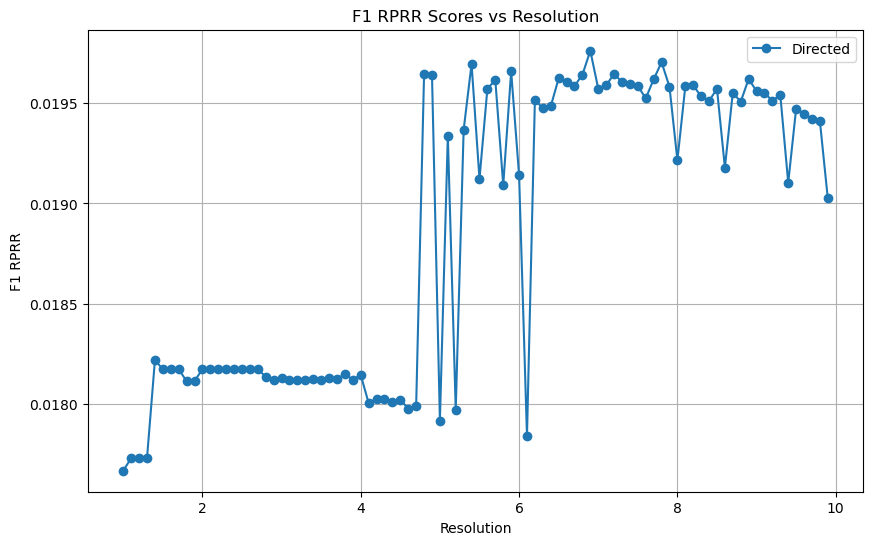

In [ ]:
plt.figure(figsize=(10, 6))

# Plot for directed scores
plt.plot(directed_scores_res['resolution'], directed_scores_res['f1rprr'], marker='o', linestyle='-', label='Directed')
plt.xlabel('Resolution')
plt.ylabel('F1 RPRR')
plt.title('F1 RPRR Scores vs Resolution')
plt.legend()
plt.grid(True)
plt.show()

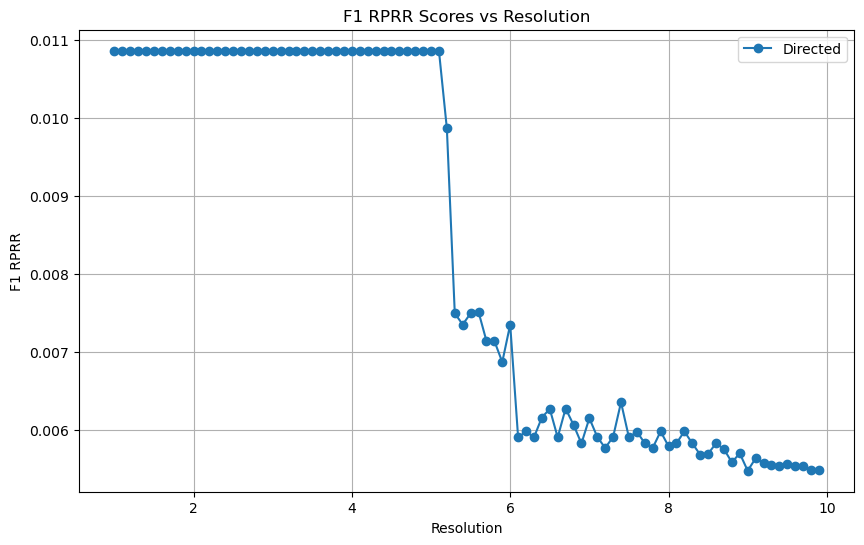

In [ ]:
plt.figure(figsize=(10, 6))

# Plot for directed scores
plt.plot(undirected_scores_res['resolution'], undirected_scores_res['f1rprr'], marker='o', linestyle='-', label='Directed')
plt.xlabel('Resolution')
plt.ylabel('F1 RPRR')
plt.title('F1 RPRR Scores vs Resolution')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
max_undirected_score_res = undirected_scores_res.loc[undirected_scores_res['f1rprr'].idxmax()]
max_directed_score_res = directed_scores_res.loc[directed_scores_res['f1rprr'].idxmax()]

print("Resolution with highest undirected F1rprr score:")
print(max_undirected_score_res)
print("Resolution with highest directed F1rprr score:")
print(max_directed_score_res)

Resolution with highest undirected F1rprr score:
resolution    1.000000
precision     0.003289
recall        0.019756
recovery      0.141503
relevance     0.152012
f1rprr        0.010860
Name: 0, dtype: float64
Resolution with highest directed F1rprr score:
resolution    6.900000
precision     0.007558
recall        0.018108
recovery      0.117365
relevance     0.157040
f1rprr        0.019761
Name: 59, dtype: float64


In [ ]:
directed_list_thresh = []
undirected_list_thresh = []

for j in range (1,100,1):
    thresh = 10**-j
    louvain_community_undirected = nx.community.louvain_communities(ecoli_trn_undirected, weight='weight', resolution=1, threshold= thresh, seed=None)
    louvain_community_directed = nx.community.louvain_communities(ecoli_trn_directed, weight='weight', resolution=1, threshold= thresh, seed=None)
    louvain_directed_sets = [set(module) for module in louvain_community_directed]
    louvain_undirected_sets = [set(module) for module in louvain_community_undirected]
    ModulesB = Modules(known_modules)
    ModulesA_directed = Modules(louvain_directed_sets)
    ModulesA_undirected = Modules(louvain_undirected_sets)
    undirect_comp = ModulesComparison(ModulesA_undirected, ModulesB, all_genes).score(None)
    direct_comp = ModulesComparison(ModulesA_directed, ModulesB, all_genes).score(None)
    directed_list_thresh.append((thresh, direct_comp['precision'], direct_comp['recall'], direct_comp['recovery'], direct_comp['relevance'], direct_comp['F1rprr']))
    undirected_list_thresh.append((thresh, undirect_comp['precision'], undirect_comp['recall'], undirect_comp['recovery'], undirect_comp['relevance'], undirect_comp['F1rprr']))

directed_scores_thresh = pd.DataFrame(directed_list_thresh, columns=['threshold', 'precision', 'recall', 'recovery', 'relevance', 'f1rprr'])
undirected_scores_thresh = pd.DataFrame(undirected_list_thresh, columns=['threshold', 'precision', 'recall', 'recovery', 'relevance', 'f1rprr'])

KeyboardInterrupt: 

In [ ]:
directed_scores_thresh

,threshold,precision,recall,recovery,relevance,f1rprr
0,1.000000e-01,0.006832,0.014902,0.169820,0.142186,0.017669
1,1.000000e-02,0.006864,0.014930,0.169733,0.142261,0.017732
2,1.000000e-03,0.006864,0.014930,0.169733,0.142261,0.017732
3,1.000000e-04,0.006864,0.014930,0.169733,0.142261,0.017732
4,1.000000e-05,0.006864,0.014930,0.169733,0.142261,0.017732
...,...,...,...,...,...,...
94,1.000000e-95,0.006864,0.014930,0.169733,0.142261,0.017732
95,1.000000e-96,0.006864,0.014930,0.169733,0.142261,0.017732
96,1.000000e-97,0.006864,0.014930,0.169733,0.142261,0.017732
97,1.000000e-98,0.006864,0.014930,0.169733,0.142261,0.017732


In [ ]:
undirected_scores_thresh

,threshold,precision,recall,recovery,relevance,f1rprr
0,1.000000e-01,0.003289,0.019756,0.141503,0.152012,0.01086
1,1.000000e-02,0.003289,0.019756,0.141503,0.152012,0.01086
2,1.000000e-03,0.003289,0.019756,0.141503,0.152012,0.01086
3,1.000000e-04,0.003289,0.019756,0.141503,0.152012,0.01086
4,1.000000e-05,0.003289,0.019756,0.141503,0.152012,0.01086
...,...,...,...,...,...,...
94,1.000000e-95,0.003289,0.019756,0.141503,0.152012,0.01086
95,1.000000e-96,0.003289,0.019756,0.141503,0.152012,0.01086
96,1.000000e-97,0.003289,0.019756,0.141503,0.152012,0.01086
97,1.000000e-98,0.003289,0.019756,0.141503,0.152012,0.01086


In [24]:
plt.figure(figsize=(10, 6))

# Plot for directed scores
plt.plot(directed_scores_thresh['threshold'], directed_scores_thresh['f1rprr'], marker='o', linestyle='-', label='Directed')
plt.xlabel('Threshold')
plt.ylabel('F1 RPRR')
plt.title('F1 RPRR Scores vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'directed_scores_thresh' is not defined

<Figure size 1000x600 with 0 Axes>

In [25]:
plt.figure(figsize=(10, 6))

# Plot for directed scores
plt.plot(undirected_scores_thresh['threshold'], undirected_scores_thresh['f1rprr'], marker='o', linestyle='-', label='Directed')
plt.xlabel('Threshold')
plt.ylabel('F1 RPRR')
plt.title('F1 RPRR Scores vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'undirected_scores_thresh' is not defined

<Figure size 1000x600 with 0 Axes>

In [ ]:
max_undirected_score_thresh = undirected_scores_thresh.loc[undirected_scores_thresh['f1rprr'].idxmax()]
max_directed_score_thresh = directed_scores_thresh.loc[directed_scores_thresh['f1rprr'].idxmax()]

print("Threshold with highest undirected F1rprr score:")
print(max_undirected_score_thresh)
print("Threshold with highest directed F1rprr score:")
print(max_directed_score_thresh)

Threshold with highest undirected F1rprr score:
threshold    0.100000
precision    0.003289
recall       0.019756
recovery     0.141503
relevance    0.152012
f1rprr       0.010860
Name: 0, dtype: float64
Threshold with highest directed F1rprr score:
threshold    1.000000e-20
precision    6.871654e-03
recall       1.501398e-02
recovery     1.699191e-01
relevance    1.426544e-01
f1rprr       1.777580e-02
Name: 19, dtype: float64


In [ ]:
directed_list_weight = []
undirected_list_weight = []

for j in range (10,100,1):
    weigh = j/10
    louvain_community_undirected = nx.community.louvain_communities(ecoli_trn_undirected, weight=weigh, resolution=1, threshold= 1e-7, seed=None)
    louvain_community_directed = nx.community.louvain_communities(ecoli_trn_directed, weight=weigh, resolution=1, threshold= 1e-7, seed=None)
    louvain_directed_sets = [set(module) for module in louvain_community_directed]
    louvain_undirected_sets = [set(module) for module in louvain_community_undirected]
    ModulesB = Modules(known_modules)
    ModulesA_directed = Modules(louvain_directed_sets)
    ModulesA_undirected = Modules(louvain_undirected_sets)
    undirect_comp = ModulesComparison(ModulesA_undirected, ModulesB, all_genes).score(None)
    direct_comp = ModulesComparison(ModulesA_directed, ModulesB, all_genes).score(None)
    directed_list_weight.append((weigh, direct_comp['precision'], direct_comp['recall'], direct_comp['recovery'], direct_comp['relevance'], direct_comp['F1rprr']))
    undirected_list_weight.append((weigh, undirect_comp['precision'], undirect_comp['recall'], undirect_comp['recovery'], undirect_comp['relevance'], undirect_comp['F1rprr']))

directed_scores_weight = pd.DataFrame(directed_list_weight, columns=['weight', 'precision', 'recall', 'recovery', 'relevance', 'f1rprr'])
undirected_scores_weight = pd.DataFrame(undirected_list_weight, columns=['weight', 'precision', 'recall', 'recovery', 'relevance', 'f1rprr'])

In [ ]:
directed_scores_weight

,weight,precision,recall,recovery,relevance,f1rprr
0,10,0.006864,0.014930,0.169733,0.142261,0.017732
1,11,0.006872,0.015014,0.169919,0.142654,0.017776
2,12,0.006864,0.014930,0.169733,0.142261,0.017732
3,13,0.006864,0.014930,0.169733,0.142261,0.017732
4,14,0.006864,0.014930,0.169733,0.142261,0.017732
...,...,...,...,...,...,...
85,95,0.006864,0.014930,0.169733,0.142261,0.017732
86,96,0.006864,0.014930,0.169733,0.142261,0.017732
87,97,0.006864,0.014930,0.169733,0.142261,0.017732
88,98,0.006864,0.014930,0.169733,0.142261,0.017732


In [ ]:
undirected_scores_weight 

,weight,precision,recall,recovery,relevance,f1rprr
0,10,0.003289,0.019756,0.141503,0.152012,0.01086
1,11,0.003289,0.019756,0.141503,0.152012,0.01086
2,12,0.003289,0.019756,0.141503,0.152012,0.01086
3,13,0.003289,0.019756,0.141503,0.152012,0.01086
4,14,0.003289,0.019756,0.141503,0.152012,0.01086
...,...,...,...,...,...,...
85,95,0.003289,0.019756,0.141503,0.152012,0.01086
86,96,0.003289,0.019756,0.141503,0.152012,0.01086
87,97,0.003289,0.019756,0.141503,0.152012,0.01086
88,98,0.003289,0.019756,0.141503,0.152012,0.01086


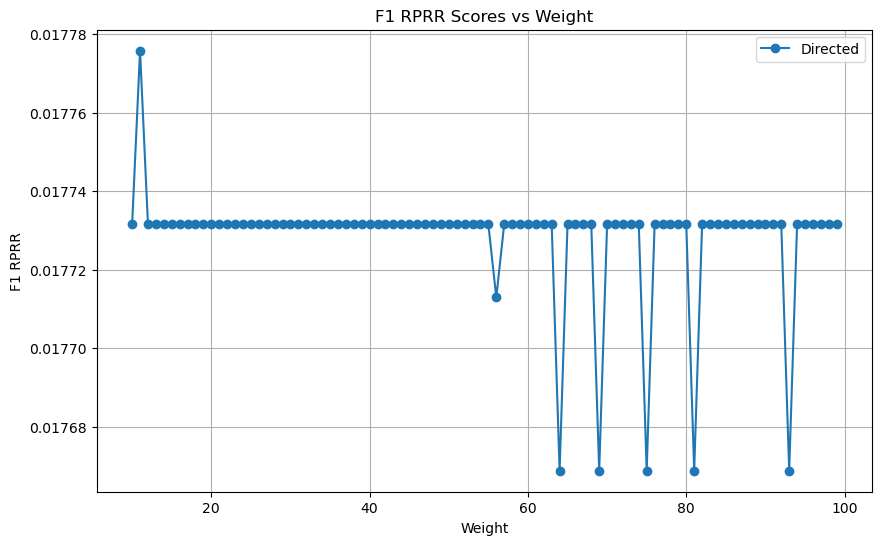

In [ ]:
plt.figure(figsize=(10, 6))

# Plot for directed scores
plt.plot(directed_scores_weight['weight'], directed_scores_weight['f1rprr'], marker='o', linestyle='-', label='Directed')
plt.xlabel('Weight')
plt.ylabel('F1 RPRR')
plt.title('F1 RPRR Scores vs Weight')
plt.legend()
plt.grid(True)
plt.show()

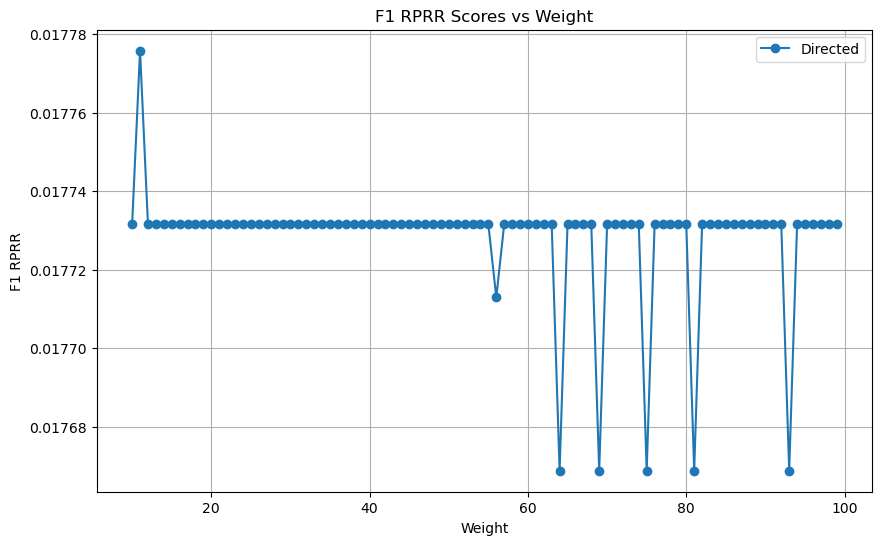

In [ ]:
plt.figure(figsize=(10, 6))

# Plot for directed scores
plt.plot(directed_scores_weight['weight'], directed_scores_weight['f1rprr'], marker='o', linestyle='-', label='Directed')
plt.xlabel('Weight')
plt.ylabel('F1 RPRR')
plt.title('F1 RPRR Scores vs Weight')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
max_undirected_score_weight = undirected_scores_weight.loc[undirected_scores_weight['f1rprr'].idxmax()]
max_directed_score_weight = directed_scores_weight.loc[directed_scores_weight['f1rprr'].idxmax()]

print("Weight with highest undirected F1rprr score:")
print(max_undirected_score_weight)
print("Weight with highest directed F1rprr score:")
print(max_directed_score_weight)

Weight with highest undirected F1rprr score:
weight       10.000000
precision     0.003289
recall        0.019756
recovery      0.141503
relevance     0.152012
f1rprr        0.010860
Name: 0, dtype: float64
Weight with highest directed F1rprr score:
weight       11.000000
precision     0.006872
recall        0.015014
recovery      0.169919
relevance     0.142654
f1rprr        0.017776
Name: 1, dtype: float64


In [26]:
directed_list = []
undirected_list = []

louvain_community_undirected = nx.community.louvain_communities(ecoli_trn_undirected, weight='weight', resolution=1, threshold= 1e-7, seed=None)
louvain_community_directed = nx.community.louvain_communities(ecoli_trn_directed, weight='weight', resolution=1, threshold= 1e-7, seed=None)
louvain_directed_sets = [set(module) for module in louvain_community_directed]
louvain_undirected_sets = [set(module) for module in louvain_community_undirected]
ModulesB = Modules(known_modules)
ModulesA_directed = Modules(louvain_directed_sets)
ModulesA_undirected = Modules(louvain_undirected_sets)
undirect_comp = ModulesComparison(ModulesA_undirected, ModulesB, all_genes).score(None)
direct_comp = ModulesComparison(ModulesA_directed, ModulesB, all_genes).score(None)
directed_list.append((direct_comp['precision'], direct_comp['recall'], direct_comp['recovery'], direct_comp['relevance'], direct_comp['F1rprr']))
undirected_list.append((undirect_comp['precision'], undirect_comp['recall'], undirect_comp['recovery'], undirect_comp['relevance'], undirect_comp['F1rprr']))

directed_scores = pd.DataFrame(directed_list, columns=['precision', 'recall', 'recovery', 'relevance', 'f1rprr'])
undirected_scores = pd.DataFrame(undirected_list, columns=['precision', 'recall', 'recovery', 'relevance', 'f1rprr'])

In [27]:
directed_scores 

,precision,recall,recovery,relevance,f1rprr
0,0.006864,0.01493,0.169733,0.142261,0.017732


In [28]:
undirected_scores

,precision,recall,recovery,relevance,f1rprr
0,0.003289,0.019756,0.141503,0.152012,0.01086


Based on these results, it appears that weight and threshold have very little impact on the resulting scores. Therefore, we should move forward optimizing resolution and edge count. 

In [9]:
directed_list = []
undirected_list = []

for i in range (1000,10000,500):
    for j in range (10,100,5):
        ecoli_trn_undirected = nx.Graph()
        ecoli_trn_undirected.add_edges_from([tuple(val) for val in genie3_undirected[['regulatoryGene', 'targetGene']].head(i).values])
        ecoli_trn_directed = nx.Graph()
        ecoli_trn_directed.add_edges_from([tuple(val) for val in genie3_directed[['regulatoryGene', 'targetGene']].head(i).values])
        res = j/10
        louvain_community_undirected = nx.community.louvain_communities(ecoli_trn_undirected, weight='weight', resolution=res, threshold=1e-7, seed=None)
        louvain_community_directed = nx.community.louvain_communities(ecoli_trn_directed, weight='weight', resolution=res, threshold=1e-7, seed=None)
        louvain_directed_sets = [set(module) for module in louvain_community_directed]
        louvain_undirected_sets = [set(module) for module in louvain_community_undirected]
        ModulesB = Modules(known_modules)
        ModulesA_directed = Modules(louvain_directed_sets)
        ModulesA_undirected = Modules(louvain_undirected_sets)
        undirect_comp = ModulesComparison(ModulesA_undirected, ModulesB, all_genes).score(None)
        direct_comp = ModulesComparison(ModulesA_directed, ModulesB, all_genes).score(None)

        directed_list.append((i, res, direct_comp['precision'], direct_comp['recall'], direct_comp['recovery'], direct_comp['relevance'], direct_comp['F1rprr']))
        undirected_list.append((i, res, undirect_comp['precision'], undirect_comp['recall'], undirect_comp['recovery'], undirect_comp['relevance'], undirect_comp['F1rprr']))

directed_scores = pd.DataFrame(directed_list, columns=['edges', 'resolution', 'precision', 'recall', 'recovery', 'relevance', 'f1rprr'])
undirected_scores = pd.DataFrame(undirected_list, columns=['edges', 'resolution', 'precision', 'recall', 'recovery', 'relevance', 'f1rprr'])

In [23]:
directed_scores

,edges,resolution,precision,recall,recovery,relevance,f1rprr
0,1000,1.0,0.006872,0.015014,0.169919,0.142654,0.017776
1,1000,1.5,0.007015,0.015402,0.174432,0.145693,0.018175
2,1000,2.0,0.007015,0.015402,0.174432,0.145693,0.018175
3,1000,2.5,0.007015,0.015402,0.174432,0.145693,0.018175
4,1000,3.0,0.006989,0.015393,0.171986,0.145654,0.018122
...,...,...,...,...,...,...,...
319,9500,7.5,0.006354,0.009585,0.086623,0.078859,0.013989
320,9500,8.0,0.006253,0.009482,0.082814,0.077478,0.013775
321,9500,8.5,0.006607,0.010520,0.087917,0.085392,0.014843
322,9500,9.0,0.006436,0.010541,0.087095,0.082903,0.014609


In [24]:
undirected_scores

,edges,resolution,precision,recall,recovery,relevance,f1rprr
0,1000,1.0,0.003289,0.019756,0.141503,0.152012,0.010860
1,1000,1.5,0.003289,0.019756,0.141503,0.152012,0.010860
2,1000,2.0,0.003289,0.019756,0.141503,0.152012,0.010860
3,1000,2.5,0.003289,0.019756,0.141503,0.152012,0.010860
4,1000,3.0,0.003289,0.019756,0.141503,0.152012,0.010860
...,...,...,...,...,...,...,...
319,9500,7.5,0.010596,0.046966,0.099024,0.288559,0.030952
320,9500,8.0,0.010477,0.046838,0.099070,0.290088,0.030688
321,9500,8.5,0.010458,0.046843,0.098182,0.289838,0.030627
322,9500,9.0,0.010433,0.047505,0.098695,0.292748,0.030664


In [27]:
max_undirected_score = undirected_scores.loc[undirected_scores['f1rprr'].idxmax()]
max_directed_score = directed_scores.loc[directed_scores['f1rprr'].idxmax()]

print("Weight with highest undirected F1rprr score:")
print(max_undirected_score)
print("Weight with highest directed F1rprr score:")
print(max_directed_score)

Weight with highest undirected F1rprr score:
edges         8500.000000
resolution       1.000000
precision        0.014107
recall           0.047608
recovery         0.102801
relevance        0.270291
f1rprr           0.037980
Name: 270, dtype: float64
Weight with highest directed F1rprr score:
edges         1000.000000
resolution       8.000000
precision        0.007558
recall           0.018081
recovery         0.106779
relevance        0.157888
f1rprr           0.019674
Name: 14, dtype: float64


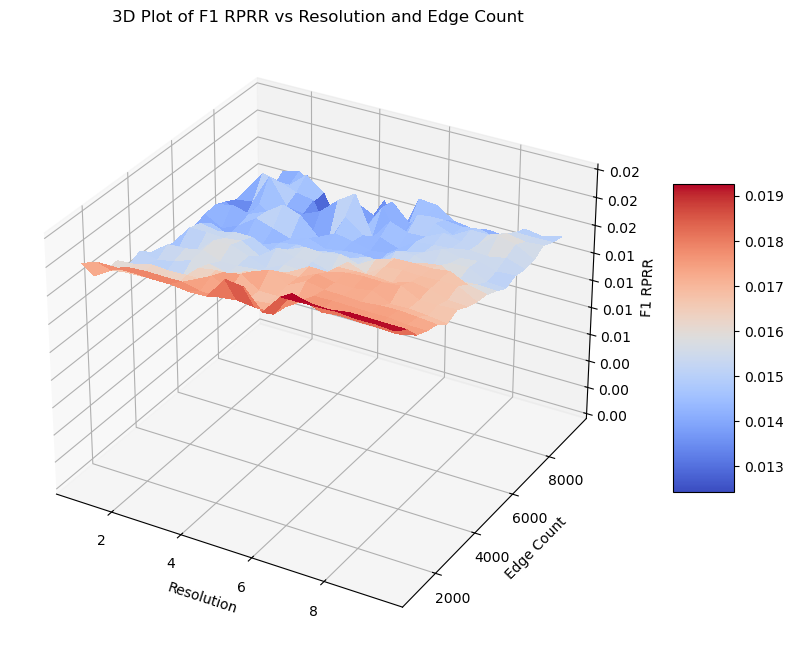

In [30]:
resolution_grid, edge_count_grid = np.meshgrid(sorted(directed_scores['resolution'].unique()), sorted(directed_scores['edges'].unique()))

f1rprr_grid_directed = directed_scores.pivot(index='edges', columns='resolution', values='f1rprr').values

# 3D Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf_directed = ax.plot_surface(resolution_grid, edge_count_grid, f1rprr_grid_directed, cmap=cm.coolwarm, linewidth=0, antialiased=False, label='Directed')

# Customize the z axis
ax.set_zlim(0, 0.02)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.02f}')

# Add labels and title
ax.set_xlabel('Resolution')
ax.set_ylabel('Edge Count')
ax.set_zlabel('F1 RPRR')
ax.set_title('3D Plot of F1 RPRR vs Resolution and Edge Count')

# Add a color bar which maps values to colors
fig.colorbar(surf_directed, shrink=0.5, aspect=5)

plt.show()

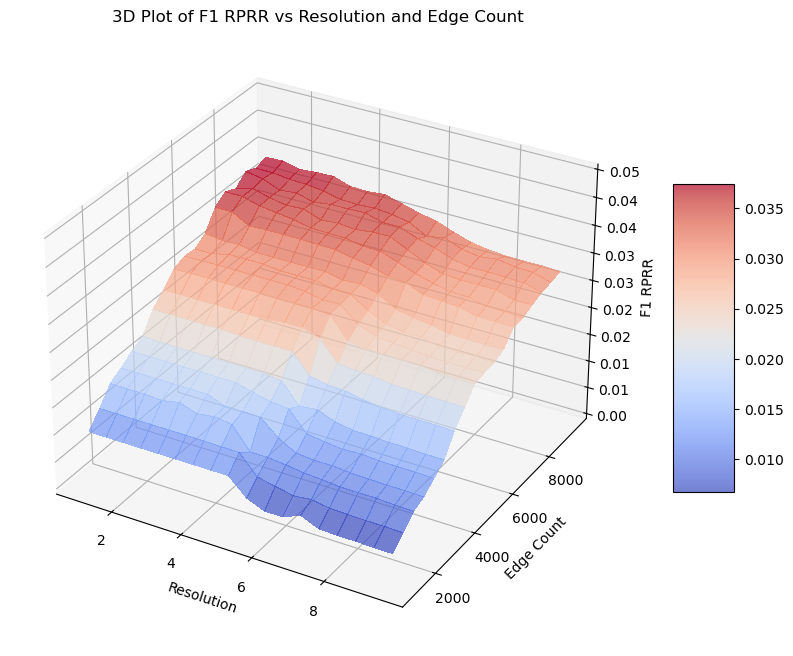

In [31]:
resolution_grid, edge_count_grid = np.meshgrid(sorted(undirected_scores['resolution'].unique()), sorted(undirected_scores['edges'].unique()))

f1rprr_grid_undirected = undirected_scores.pivot(index='edges', columns='resolution', values='f1rprr').values

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf_undirected = ax.plot_surface(resolution_grid, edge_count_grid, f1rprr_grid_undirected, cmap=cm.coolwarm, linewidth=0, antialiased=False, alpha=0.7, label='Undirected')

# Customize the z axis
ax.set_zlim(0, 0.05)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.02f}')

# Add labels and title
ax.set_xlabel('Resolution')
ax.set_ylabel('Edge Count')
ax.set_zlabel('F1 RPRR')
ax.set_title('3D Plot of F1 RPRR vs Resolution and Edge Count')

# Add a color bar which maps values to colors
fig.colorbar(surf_undirected, shrink=0.5, aspect=5)

plt.show()